# **Introduction To Standardized Precipitation Evapotranspiration Index, SPEI**



The **Standardized Precipitation Evapotranspiration Index (SPEI)**  is a widely used drought index in remote sensing and climatology that quantifies drought conditions by considering both precipitation and potential evapotranspiration (PET).

It is an extension of the Standardized Precipitation Index (SPI) but incorporates temperature data, making it more sensitive to the effects of climate change and variability.

**Key Features of SPEI:**

1. **Combines Precipitation and Temperature Data:**

SPEI uses precipitation and temperature data to calculate water balance (precipitation minus evapotranspiration).

This makes it more comprehensive than SPI, which only considers precipitation.

2. **Standardized Scale:**

Like SPI, SPEI is standardized, meaning it can be applied across different regions and time scales (e.g., 1-month, 3-month, 12-month).

The standardized values allow for comparison of drought conditions across diverse climates.

3. **Multi-Scale Analysis:**

SPEI can be computed for various time scales (short-term to long-term), making it suitable for analyzing different types of drought (e.g., meteorological, agricultural, hydrological).

4. **Sensitivity to Climate Change:**

By including temperature, SPEI accounts for the impact of rising temperatures on drought conditions, which is particularly relevant in the context of global warming.

**Calculation of SPEI:**
1. **Water Balance Calculation**:

The difference between precipitation (P) and potential evapotranspiration (PET) is calculated for a given time period.

**D = P − PET**,
where **D** is the *climatic water balance*

2. **Accumulation**:

The water balance values are accumulated over the desired time scale (e.g., 3 months, 6 months).

3. **Standardization**:

The accumulated values are fitted to a probability distribution (typically a log-logistic distribution).

The values are then transformed into a standardized index with a mean of 0 and a standard deviation of 1.

4. **Interpretation**:

*Negative* SPEI values indicate drought conditions, while *positive* values indicate wet conditions.

The magnitude of the value reflects the severity of the drought or wetness.

**Applications in Remote Sensing:**

i. **Drought Monitoring**:

* SPEI is used to monitor and assess drought conditions at regional, national, and global scales.

* Remote sensing data, such as satellite-derived precipitation (e.g., TRMM, GPM) and temperature (e.g., MODIS, ERA5), can be used to calculate SPEI.

ii. **Agricultural Drought Assessment**:

* SPEI is particularly useful for assessing agricultural drought, as it accounts for both water availability (precipitation) and water demand (evapotranspiration).

iii. **Climate Change Studies**:

* SPEI is widely used in climate change research to study trends in drought frequency, intensity, and duration.

iv. **Early Warning Systems**:

* SPEI can be integrated into early warning systems to provide timely information for drought mitigation and management.

# **Foundational Earth Engine Set Up**

In [ ]:
import ee
import geemap
import folium

Insert your ProjectID from Earth Engine

In [ ]:
geemap.ee_initialize(project='--------')

In [ ]:
Map = geemap.Map(height = 500)
Map.add("basemap_selector")

# **Subsetting To A.O.I - Mandera County, Kenya**

In [ ]:
# Load the FAO GAUL Level 2 administrative boundaries dataset
gaul = ee.FeatureCollection('FAO/GAUL/2015/level2')

# Filter the dataset for Mandera County in Kenya
roi = gaul.filter(ee.Filter.And(
    ee.Filter.eq('ADM0_NAME', 'Kenya'),         # Country name filter
    ee.Filter.eq('ADM2_NAME', 'Mandera')        # County name filter
))

mandera = roi.geometry()

In [ ]:
Map.center_object(mandera, zoom=8)

# Highlight Mandera County with a red boundary
mandera_outline = ee.Image().paint(mandera, 1, 2)  # Create outline image

Map.add_ee_layer(mandera_outline, {'palette': 'red'}, 'Mandera County Boundary')

# **SPEI Analysis**

In [ ]:
speiCollection = ee.ImageCollection('CSIC/SPEI/2_10').select('SPEI_24_month').filterDate('2021', '2023')

In [ ]:
# Function to calculate mean SPEI over the ROI
def calculate_median_spei(image):
    median_spei = image.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=mandera,
        scale=55000
    )
    return image.set('median_spei', median_spei.get('SPEI_24_month'))

# Map the function over the SPEI collection
speiCollection = speiCollection.map(calculate_median_spei)

In [ ]:
# Get the time series data
timeseries = speiCollection.aggregate_array('median_spei').getInfo()
dates = speiCollection.aggregate_array('system:time_start').getInfo()

# Convert dates to a readable format
import pandas as pd
dates = pd.to_datetime(dates, unit='ms')

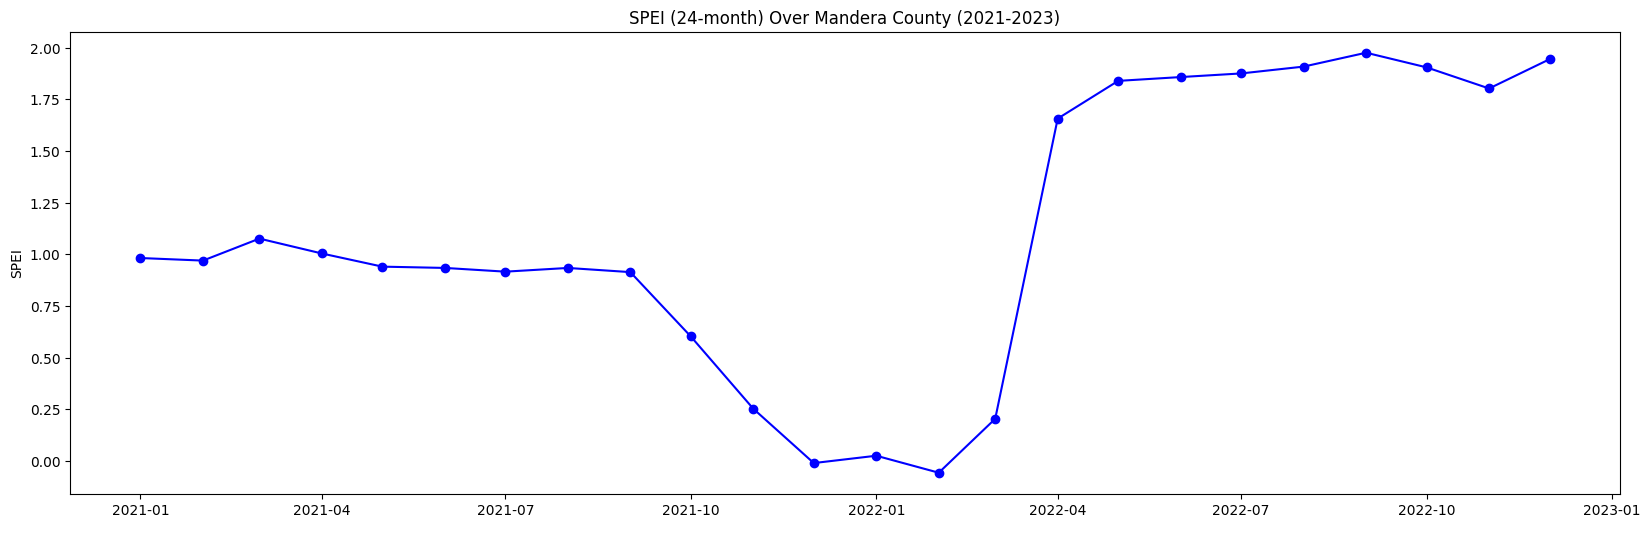

In [ ]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(20, 6))
plt.plot(dates, timeseries, marker='o', linestyle='-', color='b')
plt.title('SPEI (24-month) Over Mandera County (2021-2023)')
plt.xlabel(' ')
plt.ylabel('SPEI')
plt.grid(False)
plt.show()

# SPEI Mapping

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:

# Filter the SPEI collection for the year 2021
speiCollection2021 = ee.ImageCollection('CSIC/SPEI/2_10').select('SPEI_12_month').filterDate('2021', '2022')

# Calculate the mean SPEI for 2021
median_spei_2021 = speiCollection2021.median().clip(mandera)

# Display the mean SPEI for 2021 on the map
Map.addLayer(median_spei_2021, {'min': -2, 'max': 2, 'palette': ['red', 'yellow', 'green']}, 'SPEI 2021')

In [ ]:

# Filter the SPEI collection for the year 2022
speiCollection2022 = ee.ImageCollection('CSIC/SPEI/2_10').select('SPEI_12_month').filterDate('2022', '2023')

# Calculate the mean SPEI for 2022
median_spei_2022 = speiCollection2022.median().clip(mandera)

# Display the mean SPEI for 2021 on the map
Map.addLayer(median_spei_2022, {'min': -2, 'max': 2, 'palette': ['red', 'yellow', 'green']}, 'SPEI 2022')

In [ ]:

# Define visualization parameters
vis_params = {'min': -2, 'max': 2, 'palette': ['red', 'yellow', 'green']}

# Create a split-panel map
left_layer = geemap.ee_tile_layer(median_spei_2021, vis_params, 'SPEI 2021')
right_layer = geemap.ee_tile_layer(median_spei_2022, vis_params, 'SPEI 2022')

Map = geemap.Map()
Map.split_map(left_layer, right_layer)
Map.centerObject(mandera, 8)
Map

Map(center=[3.437846767214043, 40.73900018258642], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()